In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab   as mlab
from matplotlib import rc
from matplotlib import cm
import pandas as pd
import seaborn as sns

In [2]:
# Definiendo las masas

mKaon = 497.671
mPion = 139.560
mLambda = 1115.630
mProton = 938.272

In [3]:
# relativistic kinematics

def GetEnergies(M,m1,m2):
    E1 = (M**2+m1**2-m2**2)/(2*M)
    E2 = (M**2+m2**2-m1**2)/(2*M)
    return E1,E2
    
def GetMomentum(E,m):
    if(E >= m):
        return np.sqrt(E**2-m**2)
    else:
        print("-1")

def GetAngles():
    phi = np.random.uniform(0., 2*np.pi)
    costheta = np.random.uniform(-1., 1.)
    theta = np.arccos(costheta)
    return theta, phi

def GetMomentumVector(p,theta,phi):
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    pz = p*np.cos(theta)
    return np.array([px,py,pz])

def GetBoost(pmu,M):
    
    #Boost to lab frame
    
    E = np.random.normal(2*M,0.02*M,1)
    p = GetMomentum(E,M)
    
    gamma = E/M
    gammabeta = p/M
    
    B = np.array([
        [gamma, gammabeta, 0., 0.],
        [gammabeta, gamma, 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])
    return np.dot(pmu,B)

def GetpL(pm):
    return pm[1]

def GetpT(pm):
    return np.sqrt(pm[2]**2+pm[3]**2)
 
def GetAlpha(pL1,pL2):
    return (pL1-pL2)/(pL1+pL2)

In [4]:
# Detector efects

def GetThetaPhi(pmu):
    
    if(pmu[3] > 0.):
        theta = np.arctan(np.sqrt(pmu[1]**2+pmu[2]**2)/pmu[3])
    elif(pmu[3] < 0.):
        theta = np.arctan(np.sqrt(pmu[1]**2+pmu[2]**2)/pmu[3])+np.pi
    
    if(pmu[1] > 0. and pmu[2] > 0.):
        phi = np.arctan(pmu[2]/pmu[1])
    elif(pmu[1] < 0. and pmu[2] > 0.):
        phi = np.arctan(pmu[2]/pmu[1])+np.pi
    elif(pmu[1] < 0. and pmu[2] < 0.):
        phi = np.arctan(pmu[2]/pmu[1])+np.pi
    else:
        phi = np.arctan(pmu[2]/pmu[1])+2.*np.pi
    
    return theta,phi

In [5]:
def GetSmearing(pmu, m, sigmaE, sigmaTheta):
    
    theta, phi = GetThetaPhi(pmu)
    NewE = np.random.normal(pmu[0], abs(sigmaE*pmu[0]),1)
    Newtheta = np.random.normal(theta, abs(sigmaTheta*theta),1)
    
    if(NewE < m): # Condición on-shell
        NewE = m + sigmaE*pmu[0]
        
    Newp = GetMomentum(NewE,m)
    NewVectorp = GetMomentumVector(Newp,Newtheta,phi)
    return np.concatenate([[NewE],NewVectorp])

In [6]:
# DataFrame
names = ['Alpha','p1T','DAlpha','Dp1T']
data = pd.DataFrame(np.zeros((1000, 4)),columns=names)


# Loop over events

Nevents = 10000

for i in range(Nevents):
    
    selector = np.random.rand()
    
    if selector <= 0.5:
        M = mKaon
        m1 = mPion
        m2 = mPion
    elif 0.5 < selector <= 0.75:
        M = mLambda
        m1 = mProton
        m2 = mPion
    else:
        M = mLambda
        m1 = mPion
        m2 = mProton
  
    
    E1, E2 = GetEnergies(M,m1,m2)    
    p1, p2 = GetMomentum(E1,m1), GetMomentum(E2,m2) 
    
    theta, phi = GetAngles()
    
    Vp1 = GetMomentumVector(p1,theta,phi)
    Vp2 = -Vp1 # Conservation of momentum
    
    pm1 = np.concatenate([[E1],Vp1])
    pm2 = np.concatenate([[E2],Vp2])
       
    pm1_lab = GetBoost(pm1,M)
    pm2_lab = GetBoost(pm2,M)
    
    # Detector efects
    
    Dpm1_lab = GetSmearing(pm1_lab,m1,0.025,0.005)
    Dpm2_lab = GetSmearing(pm2_lab,m2,0.025,0.005)
    
    Alpha = GetAlpha(pm1_lab[1],pm2_lab[1])
    p1T = GetpT(pm1_lab)
    p2T = GetpT(pm2_lab)
    
    DAlpha = GetAlpha(Dpm1_lab[1],Dpm2_lab[1])
    Dp1T = GetpT(Dpm1_lab)
    Dp2T = GetpT(Dpm2_lab)
    
    
    data.loc[i,'Alpha'] = Alpha
    data.loc[i,'p1T'] = p1T
    
    data.loc[i,'DAlpha'] = DAlpha
    data.loc[i,'Dp1T'] = Dp1T

<Figure size 288x288 with 0 Axes>

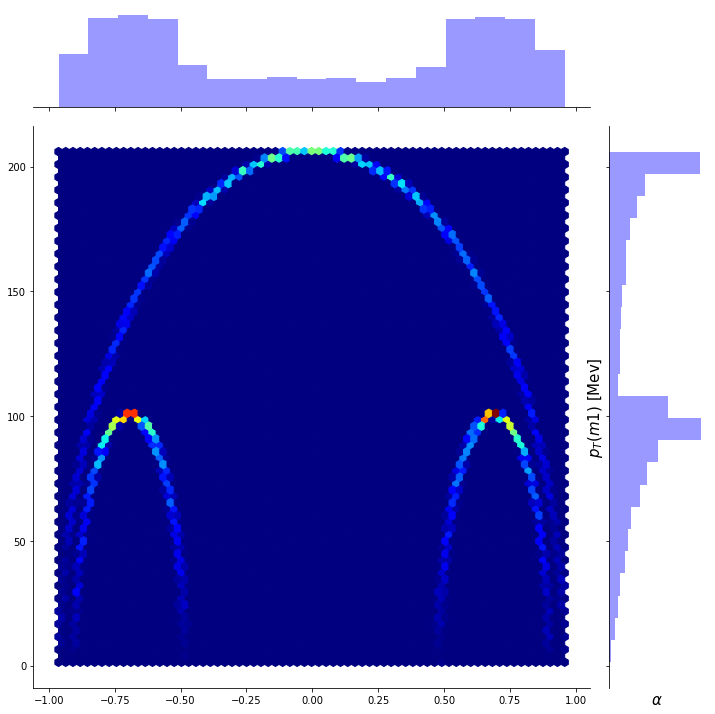

In [7]:
fig = plt.figure(figsize=(4,4))
ax = sns.jointplot(x=data['Alpha'].values, y=data['p1T'].values, kind='hex',height=10,cmap=cm.jet,color='b',gridsize=70)
plt.xlabel(r'$\alpha$', fontsize=15)
plt.ylabel(r'$p_{T}(m1)$ [Mev]', fontsize=15)

plt.savefig('Armenteros.pdf')

<Figure size 288x288 with 0 Axes>

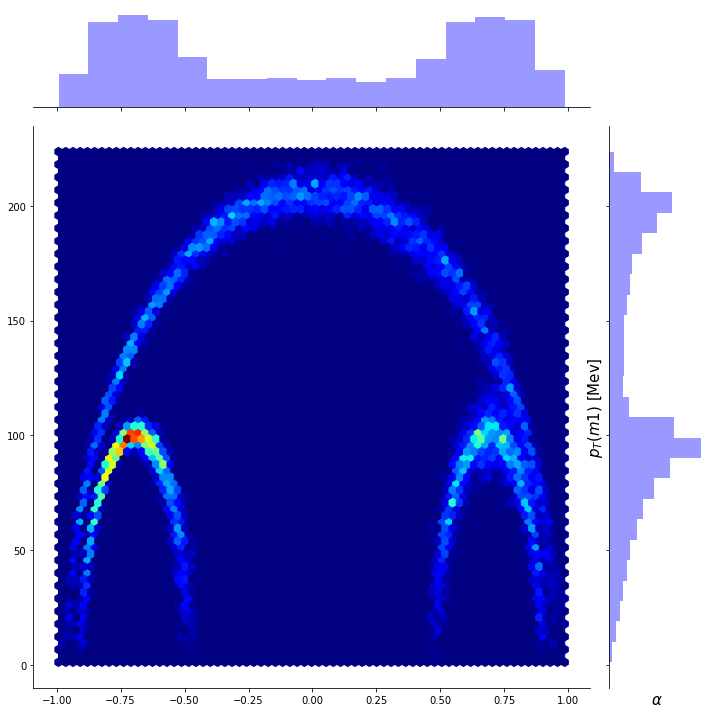

In [8]:
fig = plt.figure(figsize=(4,4))
ax = sns.jointplot(x=data['DAlpha'].values, y=data['Dp1T'].values, kind='hex',height=10,cmap=cm.jet,color='b',gridsize=70)
plt.xlabel(r'$\alpha$', fontsize=15)
plt.ylabel(r'$p_{T}(m1)$ [Mev]', fontsize=15)

plt.savefig('Armenteros_Detector.pdf')